In [2]:
# all imports
from skimage.filters import threshold_local
import numpy as np
import argparse
import cv2,imutils
from matplotlib import pyplot as plt
import numpy as np
import time as t
# https://blog.dominodatalab.com/interactive-dashboards-in-jupyter/
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import widgets
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 5, 5
from PIL import Image
from glob import glob
from statistics import mode
import os,pytesseract,editdistance,re
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import tifffile as tiff

In [3]:
# %load img_utils.py

def showimg(img):
    plt.imshow(img,cmap='gray')
    plt.show()

def resizeAndPad(img, size, padColor=0):
    '''
        Aspect Ratio Rescaling of image.
        Throws error if height / width is not generatable.
        Adds black padding to heigh / width appropriately.
    '''
    h, w = img.shape[:2]
    sh, sw = size
    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA
    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w/h

    # compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else: # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # set pad color
    if len(img.shape) is 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=padColor)

    return scaled_img

def adjust_gamma(image, gamma=1.0):
	# build a lookup table mapping the pixel values [0, 255] to
	# their adjusted gamma values
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
 
	# apply gamma correction using the lookup table
	return cv2.LUT(image, table)

def auto_canny(image, sigma=0.33):
	# compute the median of the single channel pixel intensities
	v = np.median(image)
 
	# apply automatic Canny edge detection using the computed median
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edged = cv2.Canny(image, lower, upper)
 
	# return the edged image
	return edged

In [4]:
def crop_bill_image_save_kernel_version(imgpath,outpath,kernel_sequence,
                         debugLvl=0,
                         gauss_blur_kernel=(5, 5),
                         padding=20,cannyapertureSize=5,
                         alertThreshold=40):
    image = cv2.imread(imgpath)
    orig = image.copy()
    h,w,ch=image.shape
    aspect_ratio=w/h
    origArea=w*h
    
    if debugLvl > 1:
        showimg(image)
    
    desired_height=1024
    ratio = h/ desired_height
    respective_width=int(w/ratio)
    image = imutils.resize(image,height = desired_height,width=respective_width) # we need atleast 1024 size image
    resized_aspect_ratio=respective_width/desired_height
    
    # convert the image to grayscale, blur it, and find edges in the image
    img = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    
    for name,params in kernel_sequence:
        img=apply_kernel(name,img,params)
        if debugLvl > 0:
            print('Applying kernel : '+name)
            showimg(img)
    
    (_,cnts,_) = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
#     cnts = sorted(cnts, key = cv2.contourArea, reverse = True)
    # loop over the contours
    screenCnt=[]
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.05 * peri, True)
#         if len(approx) > 3:
        screenCnt.append(approx)
        if debugLvl>1:
            x,y,w,h=cv2.boundingRect(approx)
            print('[INFO] Contour w/ approx len > 3, len = %s boundRect=%s boundRectArea',
                  len(approx),cv2.boundingRect(approx),w*h)
            print('[INFO]  Bounding Rectangle .. x,y,w,h ',cv2.boundingRect(approx))
    if debugLvl>1:
        print('Contour Count ',screenCnt)
    if len(screenCnt) <1 :
        print('[ERROR] No Contours Found !! Please check..')
        return
    
    c = max(screenCnt, key = cv2.contourArea)
    if debugLvl > 0:
        print('max contour drawn below ... ')
        img_copy=image.copy()
        cv2.drawContours(img_copy, [c], -1, (0, 255, 0), 2)
        showimg(img=img_copy)
    
    x,y,w,h=cv2.boundingRect(c)
    image2=image[y:y+h,x:x+w]
    if debugLvl > 0:
        print('Cropped Image')
        showimg(image2)
    
    # from orig image, use ratio, ratio is height ratio
    x_o,y_o,w_o,h_o=[ int(a * ratio) for a in [x,y,w,h]]
    image2=orig[y_o-padding:y_o+h_o+padding,x_o-padding:x_o+w_o+padding]
    
    if debugLvl > 0:
        print('orig/crop shape',orig.shape,image2.shape)
        print('ratio = %f , aspect_ratio= %f resized_image_aspect_ratio %f'%(ratio,
                                                                             aspect_ratio,
                                                                             resized_aspect_ratio))
        print('    x_adj,y_adj= %s x,y=%s'%((x_o,y_o),(x,y)))
        print('    w_adj,h_adj= %s w,h=%s'%((w_o,h_o),(w,h)))
        showimg(image2)
    cv2.imwrite(outpath,image2)
    
    h,w,ch=image2.shape
    resultImageAreaPercent=(100.0*w*h/origArea)
    if resultImageAreaPercent < alertThreshold:
        print('Alert ! Image Crop % < alert threshold')
        print('ImagePath %s , Processed Area %% - %s'%(outpath,"{0:.2f}".format(resultImageAreaPercent)))
        return 1
    return 0

In [5]:
# %%writefile find_contours_on_cropped_img.py
# %load find_contours_on_cropped_img.py
def run_tesseract(img,tmpdir,blur=True,thresh=False,debugLvl=0):
    image = img
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    if debugLvl>0:
        showimg(image)
    
    if debugLvl>1:
        showimg(gray)
        
    # check to see if we should apply thresholding to preprocess the image
    if thresh:
        gray = cv2.threshold(gray, 0, 255,
            cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    # make a check to see if median blurring should be done to remove noise
    elif blur:
        gray = cv2.medianBlur(gray, 3)
    
    # Save image temporarily to apply ocr
    filename = tmpdir+"{}.png".format(os.getpid())
    cv2.imwrite(filename, gray)
    
    text = pytesseract.image_to_string(Image.open(filename))
    
    if debugLvl>1:
        showimg(gray)
        print('----------Tesseract printed text below------ \n'+text)
    return text

def edge_kernel(size , kernel_type, value = -1 ):
    kernel = np.multiply(value , np.ones((size)))
    x = int(size[0]/2)
    y = int(size[1]/2)
    mid_value = -((size[0]*size[1])-1)*value
    if kernel_type == 'edge':
        mid_value = mid_value
    elif kernel_type == 'sharp':
        mid_value = mid_value-2
    kernel[x,y] = mid_value
    return kernel

def isValidContour(cnt,orig_area,big_cnt_area_prcnt_th,smal_cnt_area_prcnt_th):
    x,y,w,h = cv2.boundingRect(cnt)
    if (w*h <= orig_area*big_cnt_area_prcnt_th/100 ) and (w*h >= orig_area*smal_cnt_area_prcnt_th/100):
        return True
    return False

def find_contours_on_cropped_img( fpath,outfilepath,big_cnt_area_prcnt_th=70, smal_cnt_area_prcnt_th=0.2,
                                 debug = 0):
    '''
        Hierarchy in contours is formatted as follows
            [Next, Previous, First_Child, Parent]
            *"Next denotes next contour at the same hierarchical level."*
            *"Previous denotes previous contour at the same hierarchical level."*
            *"First_Child denotes its first child contour."*
            *"Parent denotes index of its parent contour."*
    '''
    img = cv2.imread(fpath)
    orig=img.copy()
    w,h,ch=img.shape
    orig_area=w*h
    c_img = img.copy()
    
    img_median = cv2.medianBlur(img,11) # remove salt and pepper noise
    img_median = cv2.bilateralFilter(img_median,11,75,75) # keep edges sharp
    #     img_median = cv2.GaussianBlur(img,(9,9),-1) # gaussian blur not working here
    
    kernel = edge_kernel((5,5) ,'edge', -1)
    filtered = cv2.filter2D(img_median,-1,kernel)
    
    dil_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (9,9))
    dilated = cv2.dilate(filtered,dil_kernel,iterations = 1)
    
    if debug > 0:
        showimg(filtered)
        showimg(dilated)
        
    img_grey = cv2.cvtColor(dilated, cv2.COLOR_BGR2GRAY)
    th = cv2.adaptiveThreshold(img_grey,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,13,3)
#     th = cv2.adaptiveThreshold(img_grey,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,7,-5)
    #if second paramter is increased than information is lost due to which all rectangles are not identified 
    th_median = cv2.medianBlur(th,1)
    
    im2, contours, hierarchy = cv2.findContours(th_median,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    #tbd clean hierarchy array
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        if isValidContour(cnt,orig_area,big_cnt_area_prcnt_th,smal_cnt_area_prcnt_th):
            i = cv2.rectangle(c_img,(x,y),(x+w,y+h),(0,255,0),2)
    
    if debug > 0:
        print('Final image ')
        plt.imshow(c_img,cmap='gray')
        plt.show()
        
        if debug > 1:
            print('img_median')
            plt.imshow(img_median ,cmap='gray')
            plt.show()

            print('filtered')
            plt.imshow(filtered ,cmap='gray')
            plt.show()

            print('dilated')
            plt.imshow(dilated ,cmap='gray')
            plt.show()

            print('img_grey')
            plt.imshow(img_grey,cmap='gray')
            plt.show()

            print('th')
            plt.imshow(th ,cmap='gray')
            plt.show()

            print('th_median')
            plt.imshow(th_median ,cmap='gray')
            plt.show()
    cv2.imwrite(outfilepath ,c_img)
    return orig,orig_area,contours,hierarchy

In [6]:
# %load contour_precedence_txt_keys_utils.py
# Util functions for below
def get_contour_precedence(contour, cols):
    '''
        contour ... current contour
        cols ... original image width
    '''
    tolerance_factor = 10
    x,y,w,h = cv2.boundingRect(contour)
    return (y*cols/50) + x + h + w
    #return ((origin[1] // tolerance_factor) * tolerance_factor) * cols + origin[0]

def draw_contours(img,contours):
    img=img.copy()
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        i = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    return img

def crop_contour(img,cnt):
    x,y,w,h=cv2.boundingRect(cnt)
    return img[y:y+h,x:x+w]

def process_string(input_str):
    token = input_str.replace('\n', ' ').replace('\r', '')
    token = re.sub( '\s+', ' ',token)
    token = token.strip().lower()
    return token

def get_best_editdistance(a,b):
    a = process_string(a)
    b = process_string(b)
    return editdistance.eval(a,b)

def is_subseq(x, y):
    it = iter(y)
    return all(any(c == ch for c in it) for ch in x)

def getMatchingKeys(txt,key_n_position):
    matchingKeys=[]
    for k in key_n_position:
        # distance=get_best_editdistance(k,txt)
        #if is_subseq(k,txt):# distance < int(len(k)/2) or 
        if k in process_string(txt):
            matchingKeys.append(k)
    return matchingKeys

In [7]:
fpath='/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/16prediction.png'
outdir='/home/ydalal/Downloads/tmp/'

fname = fpath.split('/')[-1]
outpath=outdir+fname

In [8]:
def find_contours_on_cropped_img_printedbills(fpath,outfilepath,kernel_sequence,
                                              big_cnt_area_prcnt_th=80,
                                              smal_cnt_area_prcnt_th=0.01,
                                              debug = 0):
    img = None
    if fpath.split('/')[-1].split('.')[1]=='tiff':
        img = tiff.imread(fpath)
    else:
        img = cv2.imread(fpath)
    
    orig=img.copy()
    w,h,ch=img.shape
    orig_area=w*h
    c_img = img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if debug >0:
        showimg(img)
    for name,params in kernel_sequence:
        img=apply_kernel(name,img,params)
        if debug > 0:
            print('Applying kernel : '+name)
            showimg(img)
    
    im2, contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        if isValidContour(cnt,orig_area,big_cnt_area_prcnt_th,smal_cnt_area_prcnt_th,):
            i = cv2.rectangle(c_img,(x,y),(x+w,y+h),(0,255,0),2)
    
    cv2.imwrite(outfilepath ,c_img)
    
    #return orig,orig_area,contours,hierarchy

In [9]:
# %load kernel_utils.py
def apply_kernel(name,img,params):
    if name == 'gauss':
        return cv2.GaussianBlur(img,*params) 
    if name == 'median':
        return cv2.medianBlur(img,*params)
    if name == 'filter2d':
        return cv2.filter2D(img,*params)
    if name == 'bilateral':
        return cv2.bilateralFilter(img,*params) # keep edges sharp
    if name == 'erod':
        return cv2.erode(img,*params)
    if name == 'dilate':
        return cv2.dilate(img,*params)
    if name == 'closing':
        return cv2.morphologyEx(img,*params)
    if name == 'opening':
        return cv2.morphologyEx(img,*params)
    if name == 'tophat':
        return cv2.morphologyEx(img,*params)
    if name == 'adaptthgauss':
        return cv2.adaptiveThreshold(img,*params)
    if name == 'gamma':
        return adjust_gamma(img,*params)
    if name == 'auto_canny':
        return auto_canny(img,*params)
    if name == 'binary':
        _,img=cv2.threshold(img,*params)
        return img
    if name == 'fastNlMeansDenoise':
        img=cv2.fastNlMeansDenoisingColored(cv2.cvtColor(img,),*params)
        return img
    if name == 'bgr2gray':
        img = 255*(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) > 5).astype('uint8')
        return img

### Test on a Single Bill

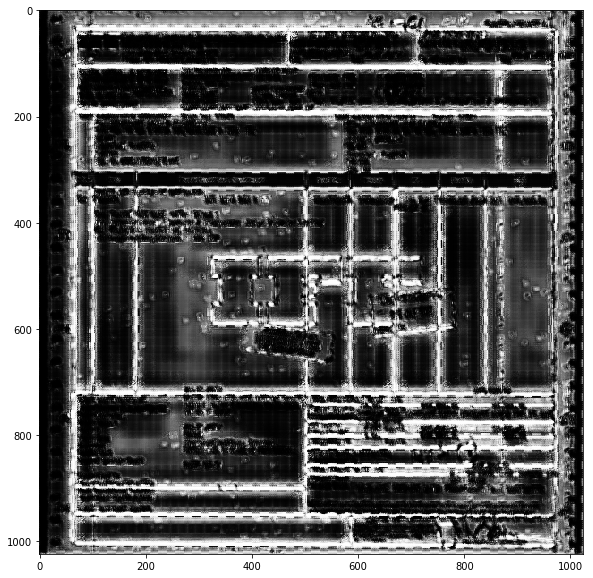

Applying kernel : median


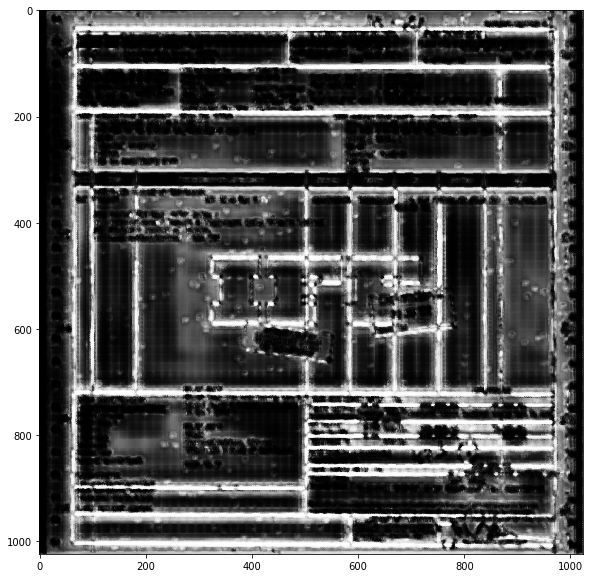

Applying kernel : binary


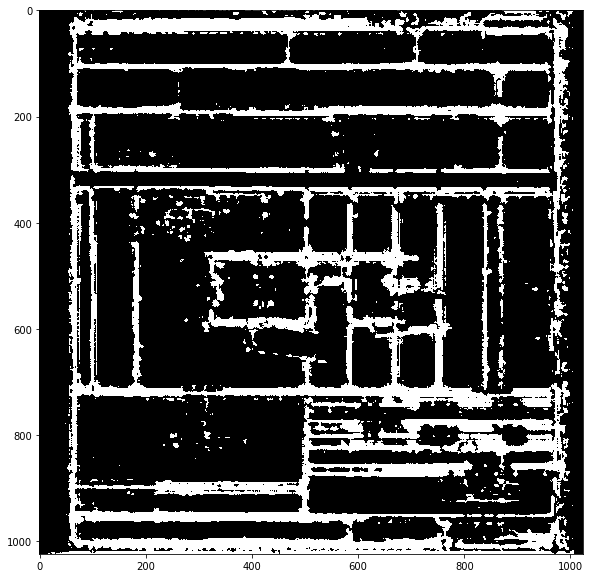

Applying kernel : closing


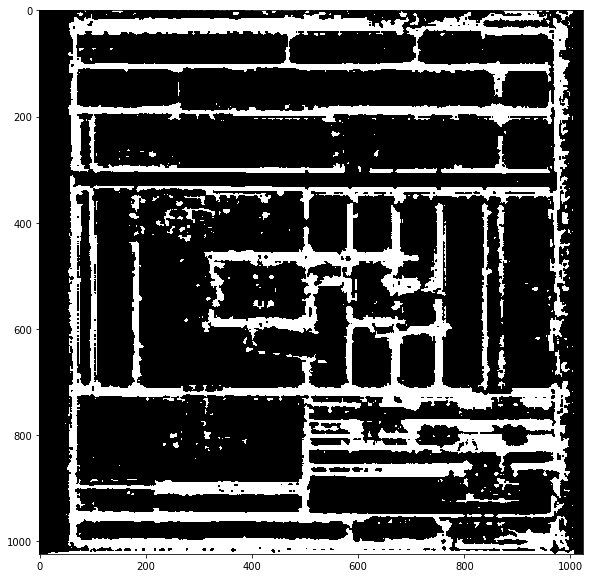

In [10]:
# Test Kernel Sequence on Single Bill
rcParams['figure.figsize'] = 10, 10

kernel_sequence=[]
# kernel_sequence.append(('bilateral',[11,75,75]))
# kernel_sequence.append(('bilateral',[11,75,75]))
kernel_sequence.append(('median',[3]))
# kernel_sequence.append(('erod',[cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3)),-7]))
# kernel_sequence.append(('filter2d',[-1,edge_kernel((7,7) ,'edge',3)]))
kernel_sequence.append(('binary',[127,255,cv2.THRESH_BINARY]))
# kernel_sequence.append(('gauss',[(11,11),-3]))
# kernel_sequence.append(('adaptthgauss',[255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,3,2]))
# kernel_sequence.append(('opening',[cv2.MORPH_OPEN, np.ones((3,3),np.uint8)]))
kernel_sequence.append(('closing',[cv2.MORPH_CLOSE, np.ones((3,3),np.uint8)]))
# kernel_sequence.append(('dilate',[cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3)),1]))
# kernel_sequence.append(('tophat',[cv2.MORPH_TOPHAT, np.ones((3,3),np.uint8)]))

find_contours_on_cropped_img_printedbills(
    fpath='/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/53prediction.png',
    outfilepath='/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/53prediction_0.png',
    kernel_sequence=kernel_sequence,
    big_cnt_area_prcnt_th=60,
    smal_cnt_area_prcnt_th=.02,
    debug=1)

In [136]:
# import numpy as np
# import cv2

# fpath='/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/53prediction.png'
# outfilepath='/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/53prediction_0.png'

# gray = cv2.imread(fpath)
# edges = cv2.Canny(gray,50,150,apertureSize = 3)
# # _,gray=cv2.threshold(gray,127,255,cv2.THRESH_BINARY)
# # _,edges=cv2.threshold(gray,127,255,cv2.THRESH_BINARY_INV)

# cv2.imwrite('/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/edges-50-150.jpg',gray)
# minLineLength=80
# lines = cv2.HoughLinesP(image=edges,
#                         rho=1,
#                         theta=np.pi/180, 
#                         threshold=100,
#                         lines=np.array([]),
#                         minLineLength=minLineLength,
#                         maxLineGap=80)
# a,b,c = lines.shape
# for i in range(a):
#     cv2.line(gray, (lines[i][0][0], lines[i][0][1]), (lines[i][0][2], lines[i][0][3]), (0, 0, 255), 3, cv2.LINE_AA)
#     cv2.imwrite('/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/houghlines5.jpg',gray)

### Run above kernels on all images

In [12]:
# Apply above kernels to DL predicted images
kernel_sequence=[]
# # kernel_sequence.append(('bilateral',[11,75,75]))
# # kernel_sequence.append(('bilateral',[11,75,75]))
# kernel_sequence.append(('median',[3]))
# # kernel_sequence.append(('gauss',[(11,11),-3]))
# # kernel_sequence.append(('erod',[cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5)),-1]))
# # kernel_sequence.append(('adaptthgauss',[255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,3,2]))
# kernel_sequence.append(('binary',[127,255,cv2.THRESH_BINARY]))
# # kernel_sequence.append(('opening',[cv2.MORPH_OPEN, np.ones((3,3),np.uint8)]))
# kernel_sequence.append(('closing',[cv2.MORPH_CLOSE, np.ones((3,3),np.uint8)]))
# # kernel_sequence.append(('dilate',[cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3)),1]))
# # kernel_sequence.append(('tophat',[cv2.MORPH_TOPHAT, np.ones((3,3),np.uint8)]))

kernel_sequence.append(('median',[3]))
kernel_sequence.append(('gauss',[(11,11),-3]))
# kernel_sequence.append(('adaptthgauss',[255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,3,2]))
kernel_sequence.append(('binary',[127,255,cv2.THRESH_BINARY]))
# kernel_sequence.append(('opening',[cv2.MORPH_OPEN, np.ones((3,3),np.uint8)]))
kernel_sequence.append(('erod',[cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3)),-1]))
# kernel_sequence.append(('filter2d',[-1,edge_kernel((7,7) ,'edge',7)]))
# kernel_sequence.append(('closing',[cv2.MORPH_CLOSE, np.ones((3,3),np.uint8)]))
# kernel_sequence.append(('dilate',[cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3)),1]))

for fpath in glob('/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/*prediction.png'):
    outpath = "/".join(fpath.split('/')[:-1])+'/dl_contours/'+fpath.split('/')[-1].split('.png')[0]+'_0.png'
    print(outpath)
    find_contours_on_cropped_img_printedbills(
        fpath=fpath,
        outfilepath=outpath ,
        kernel_sequence=kernel_sequence,
        big_cnt_area_prcnt_th=80,
        smal_cnt_area_prcnt_th=.02,
        debug=0)

/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/175prediction_0.png
/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/72prediction_0.png
/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/79prediction_0.png
/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/106prediction_0.png
/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/42prediction_0.png
/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/30prediction_0.png
/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/73prediction_0.png
/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/214prediction_0.png
/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/229predi

/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/202prediction_0.png
/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/186prediction_0.png
/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/102prediction_0.png
/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/2prediction_0.png
/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/114prediction_0.png
/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/93prediction_0.png
/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/203prediction_0.png
/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/172prediction_0.png
/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/237pre

/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/65prediction_0.png
/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/18prediction_0.png
/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/49prediction_0.png
/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/83prediction_0.png
/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/14prediction_0.png
/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/138prediction_0.png
/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/130prediction_0.png
/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/118prediction_0.png
/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/194predi

/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/99prediction_0.png
/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/142prediction_0.png
/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/161prediction_0.png
/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/8prediction_0.png
/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/105prediction_0.png
/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/276prediction_0.png
/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/86prediction_0.png
/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/135prediction_0.png
/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/238pred

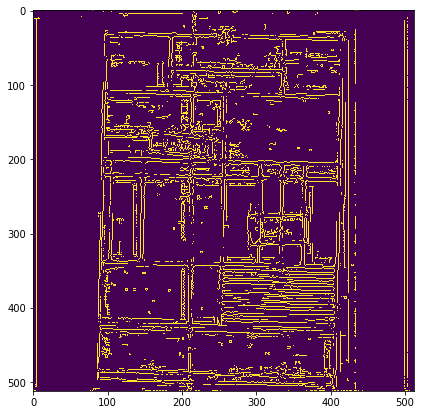

True

In [50]:
import cv2
import numpy as np

img = cv2.imread('/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/5prediction.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,150,apertureSize = 3)

plt.imshow(edges)
plt.show()
lines = cv2.HoughLines(edges,1,np.pi/180,200)
for rho,theta in lines[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
cv2.imwrite('/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/houghlines3.jpg',img)

In [ ]:
fpath='/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/68prediction.png'

img = cv2.imread(fpath)
img_bw = 255*(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) > 5).astype('uint8')
se1 = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
se2 = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
mask = cv2.morphologyEx(img_bw, cv2.MORPH_CLOSE, se1)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, se2)
mask = np.dstack([mask, mask, mask]) / 255
out = img * mask
outfilepath='/home/ydalal/rasidrev/src_other_dl_projects/Keras_HED-master/results/predictions/dl_contours/68prediction_0.png'
cv2.imwrite(outfilepath ,out)

In [8]:
# Apply Above kernel Sequence to Multiple Bills for evaluation

# input_files='../resources/bhavuk/oct_mar/anjali/Invoices/*.tif'
# outdir='../resources/bhavuk/oct_mar/anjali/Invoices_rasidrev/' # 278 processed

# input_files='../resources/bhavuk/oct_mar/anjali/invoices_other_than_blank/*.tif' 
# outdir='../resources/bhavuk/oct_mar/anjali/invoices_other_than_blank_rasidrev/' # 171 processed

# input_files='../resources/bhavuk/oct_mar/Karan_p/Invoices/*.tif' 
# outdir='../resources/bhavuk/oct_mar/Karan_p/Invoices_rasidrev/' # 257 processed

# input_files='../resources/bhavuk/Bhavuk/Invoices_MQ_UTk_Local/Invoices/*.tif' 
# outdir="/".join(input_files.split('/')[0:-1])+'_rasidrev/' # 258 processed

input_files='../resources/jeetschool/*.jpg' 
outdir="/".join(input_files.split('/')[0:-1])+'_rasidrev/' # 

if not os.path.exists(outdir):
    os.makedirs(outdir)
else:
    print('[ERROR] output directory already exists !!')
    exit(1)

anjali_photos_kernel_sequence=[]
anjali_photos_kernel_sequence.append(('median',[3]))
anjali_photos_kernel_sequence.append(('erod',[cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5)),-1]))
anjali_photos_kernel_sequence.append(('filter2d',[-1,edge_kernel((15,15) ,'edge',15)]))

lineno=0
for fpath in glob(input_files):
    fpath=os.path.abspath(fpath)
    fname=fpath.split('/')[-1]
    find_contours_on_cropped_img_printedbills(fpath=fpath,
                                          outfilepath=outdir+fname,
                                          kernel_sequence=anjali_photos_kernel_sequence,
                                          big_cnt_area_prcnt_th=80,
                                          smal_cnt_area_prcnt_th=.3,
                                          debug=0)
    lineno+=1
    print('Processed ... ',lineno)

Processed ...  1
Processed ...  2
Processed ...  3
Processed ...  4


### Jeet Arya School Bills Processing

#### Crop Kernels Adjustment

In [85]:
# Crop Kernels Adjustment
inputDir='../resources/jeetschool/'
outdir='../resources/jeetschool_smart/'

jarya_crop_kernels=[]
jarya_crop_kernels.append(('median',[3]))
jarya_crop_kernels.append(('gauss',[(3,3),5]))
jarya_crop_kernels.append(('auto_canny',[.33]))
jarya_crop_kernels.append(('filter2d',[-1,edge_kernel((5,5) ,'edge',5)]))
jarya_crop_kernels.append(('closing',[cv2.MORPH_CLOSE, np.ones((5,5),np.uint8)]))
jarya_crop_kernels.append(('opening',[cv2.MORPH_OPEN, np.ones((5,5),np.uint8)]))

for imgpath in glob(inputDir+'IM*'):
    fname=imgpath.split('/')[-1]
    crop_bill_image_save_kernel_version(imgpath,outdir+fname,
                                    kernel_sequence=jarya_crop_kernels,
                                    padding=20,
                                    debugLvl=0,
                                    gauss_blur_kernel=(3,3))

Alert ! Image Crop % < alert threshold
ImagePath ../resources/jeetschool_smart/IMG_20171127_114340808.jpg , Processed Area % - 38.07
Alert ! Image Crop % < alert threshold
ImagePath ../resources/jeetschool_smart/IMG_20171127_113342599.jpg , Processed Area % - 28.79
Alert ! Image Crop % < alert threshold
ImagePath ../resources/jeetschool_smart/IMG_20171127_112405731.jpg , Processed Area % - 0.00


In [86]:
# Find Contours Using Kernels
input_files='../resources/jeetschool_smart/*.jpg' 
outdir="/".join(input_files.split('/')[0:-1])+'_rasidrev/' # 

if not os.path.exists(outdir):
    os.makedirs(outdir)
else:
    print('[WARNING] output directory already exists !!')

jarya_kernel_sequence=[]

jarya_kernel_sequence.append(('median',[3]))
jarya_kernel_sequence.append(('gauss',[(5,5),5]))
jarya_kernel_sequence.append(('adaptthgauss',[255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2]))
jarya_kernel_sequence.append(('filter2d',[-1,edge_kernel((7,7) ,'edge',7)]))

lineno=0
for fpath in glob(input_files):
    fpath=os.path.abspath(fpath)
    print(fpath)
    fname=fpath.split('/')[-1]
    find_contours_on_cropped_img_printedbills(fpath=fpath,
                                          outfilepath=outdir+fname,
                                          kernel_sequence=jarya_kernel_sequence,
                                          big_cnt_area_prcnt_th=80,
                                          smal_cnt_area_prcnt_th=.3,
                                          debug=0)
    lineno+=1
    print('Processed ... ',lineno)

[WARNING] output directory already exists !!
/home/ydalal/rasidrev/resources/jeetschool_smart/IMG_20171127_114340808.jpg
Processed ...  1
/home/ydalal/rasidrev/resources/jeetschool_smart/IMG_20171127_103949255.jpg
Processed ...  2
/home/ydalal/rasidrev/resources/jeetschool_smart/IMG_20171127_121748095.jpg
Processed ...  3
/home/ydalal/rasidrev/resources/jeetschool_smart/IMG_20171127_115156790.jpg
Processed ...  4
/home/ydalal/rasidrev/resources/jeetschool_smart/IMG_20171127_115404990.jpg
Processed ...  5
/home/ydalal/rasidrev/resources/jeetschool_smart/IMG_20171127_122143963.jpg
Processed ...  6
/home/ydalal/rasidrev/resources/jeetschool_smart/IMG_20171127_114538994.jpg
Processed ...  7
/home/ydalal/rasidrev/resources/jeetschool_smart/IMG_20171127_122056656.jpg
Processed ...  8
/home/ydalal/rasidrev/resources/jeetschool_smart/IMG_20171127_113342599.jpg
Processed ...  9
/home/ydalal/rasidrev/resources/jeetschool_smart/IMG_20171127_115553581.jpg
Processed ...  10
/home/ydalal/rasidrev/re

In [ ]:
# jarya_kernel_sequence.append(('erod',[cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5)),-1]))
# kernel_sequence.append(('opening',[cv2.MORPH_OPEN, np.ones((3,3),np.uint8)]))
# kernel_sequence.append(('closing',[cv2.MORPH_CLOSE, np.ones((3,3),np.uint8)]))
# kernel_sequence.append(('tophat',[cv2.MORPH_TOPHAT, np.ones((3,3),np.uint8)]))
# kernel_sequence.append(('bilateral',[11,75,75]))
# kernel_sequence.append(('dilate',[cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3)),1]))
# jarya_kernel_sequence.append(('median',[3]))
# jarya_kernel_sequence.append(('gauss',[(11,11),10]))
# jarya_kernel_sequence.append(('erod',[cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5)),-1]))
# kernel_sequence.append(('opening',[cv2.MORPH_OPEN, np.ones((3,3),np.uint8)]))
# jarya_kernel_sequence.append(('adaptthgauss',[255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2]))
# jarya_kernel_sequence.append(('filter2d',[-1,edge_kernel((15,15) ,'edge',15)]))
# kernel_sequence.append(('closing',[cv2.MORPH_CLOSE, np.ones((3,3),np.uint8)]))
# kernel_sequence.append(('tophat',[cv2.MORPH_TOPHAT, np.ones((3,3),np.uint8)]))
# kernel_sequence.append(('bilateral',[11,75,75]))
# kernel_sequence.append(('dilate',[cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3)),1]))
#gray = cv2.bilateralFilter(gray,1,570,750)

In [193]:
#     img_median = cv2.medianBlur(img,3) # remove salt and pepper noise
#     th = cv2.adaptiveThreshold(img_grey,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,13,3)
#     th = cv2.adaptiveThreshold(img_grey,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,7,-5)
    #if second paramter is increased than information is lost due to which all rectangles are not identified 
#     th_median = 